# Models at a wind state

In [19]:
%load_ext kedro.extras.extensions.ipython
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs

from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm
from vct.bokeh_plotting import create_tab
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict
from sklearn.metrics import r2_score, mean_absolute_error
from phd.pipelines.resimulate_with_autopilot.nodes import find_initial_equilibrium_rev
from vessel_manoeuvring_models.prime_system import PrimeSystem
from numpy.testing import assert_almost_equal

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger()
handler = log.handlers[0]
handler.setLevel(logging.ERROR)  # Remove info 

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (15,10)


from vct.bokeh_plotting import create_tab
import optimize_delta

import yaml

with open('../styles.yml', 'r') as file:
    styles = yaml.safe_load(file)

In [21]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")
models_ID_hull = catalog.load(f"{ship}.models_ID_hull")
models_ID_hull_rudder = catalog.load(f"{ship}.models_ID_hull_rudder")
models_VCT_MDL = catalog.load(f"{ship}.models_VCT_MDL")

In [22]:
models = {
    'VCT' : models_VCT_MDL['semiempirical_covered'](),
    'ID hull' : models_ID_hull['semiempirical_covered'](),
    'ID hull rudder' : models_ID_hull_rudder['Abkowitz'](),
}


In [23]:
model = models['VCT']

In [24]:
for name, subsytem in model.subsystems.items():
    try:
        subsytem.ship
    except:
        raise ValueError(name)

In [25]:
model.show_subsystems()

hull: PrimeEquationSubSystem
propellers: PropellersSimpleSystem
rudder_port: SemiempiricalRudderSystemCovered
rudder_stbd: SemiempiricalRudderSystemCovered
rudders: Rudders
rudder_hull_interaction: RudderHullInteractionSystem
wind_force: DummyWindForceSystem


In [26]:
N = 10
data = pd.DataFrame(index=np.arange(N))
data[model.states_str] = 0
data[model.control_keys] = 0
data['beta'] = np.deg2rad(np.linspace(-10,10,N))
data['V'] = 0.8
data['u'] = data['V']*np.cos(data['beta'])
data['v'] = -data['V']*np.sin(data['beta'])
data['thrust_port'] = 5
data['thrust_stbd'] = 5
data['thrust'] = data['thrust_port'] + data['thrust_stbd']

In [27]:
dataframes={}
for name, model_ in models.items():
    dataframes[name] = predict(model=model_, data=data)

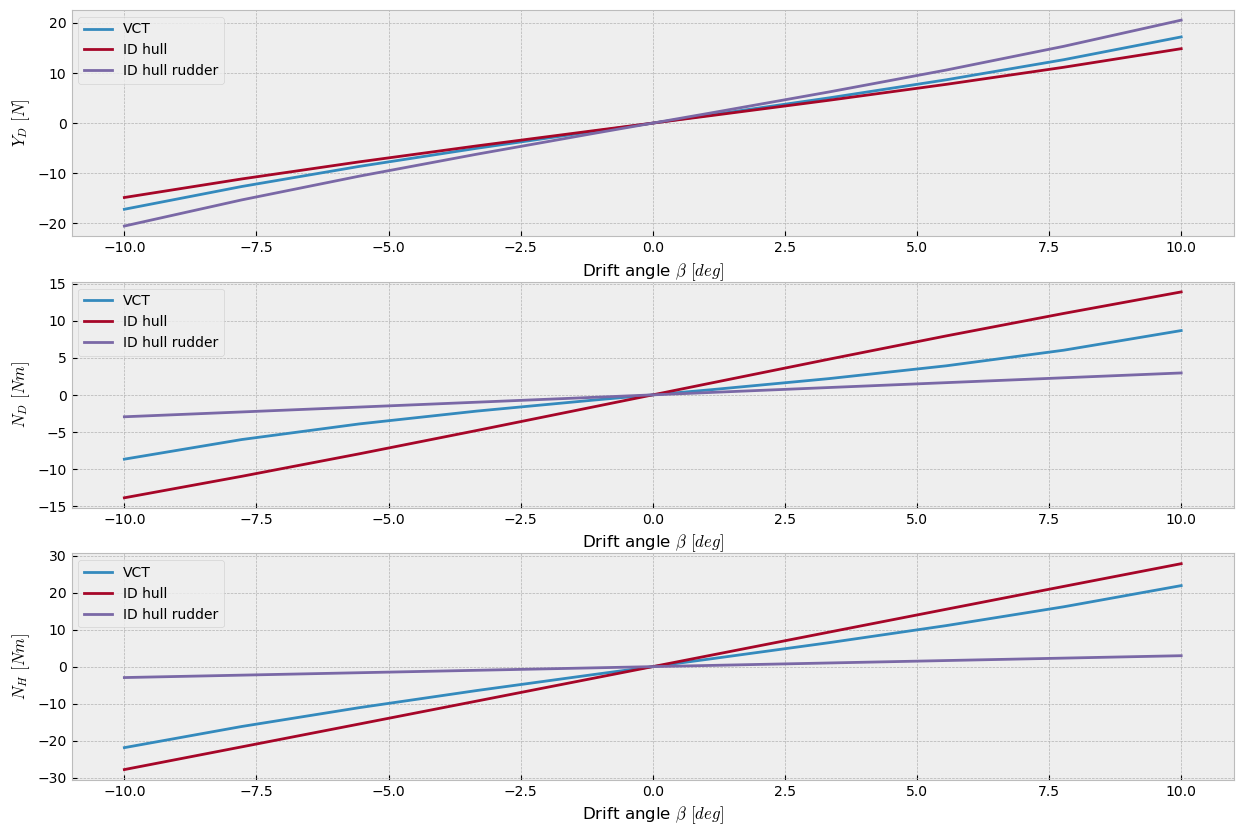

In [28]:
fig,axes=plt.subplots(nrows=3)

ylims={}
for ax,y,unit in zip(axes,['Y_D','N_D','N_H'],['N','Nm','Nm']):

    for name,df in dataframes.items():
        df['beta_deg'] = np.rad2deg(df['beta'])
        df.plot(x='beta_deg', y=y, label=name, ax=ax)
    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
    ax.set_ylabel(fr'${y}$ $[{unit}]$')
    ylims[y]=ax.get_ylim()

In [29]:
#optimization_result = optimize_delta.fit(model=model, data=data)

In [30]:
#optimization_result

In [31]:
dataframes_optimized={}
for name, model_ in models.items():
    
    data_optimized = data.copy()
    optimization_result = optimize_delta.fit(model=model_, data=data_optimized)
    data_optimized['delta'] = optimization_result.x
    dataframes_optimized[name] = predict(model=model_, data=data_optimized)
    #dataframes_optimized[name]['delta'] = data_optimized['delta']

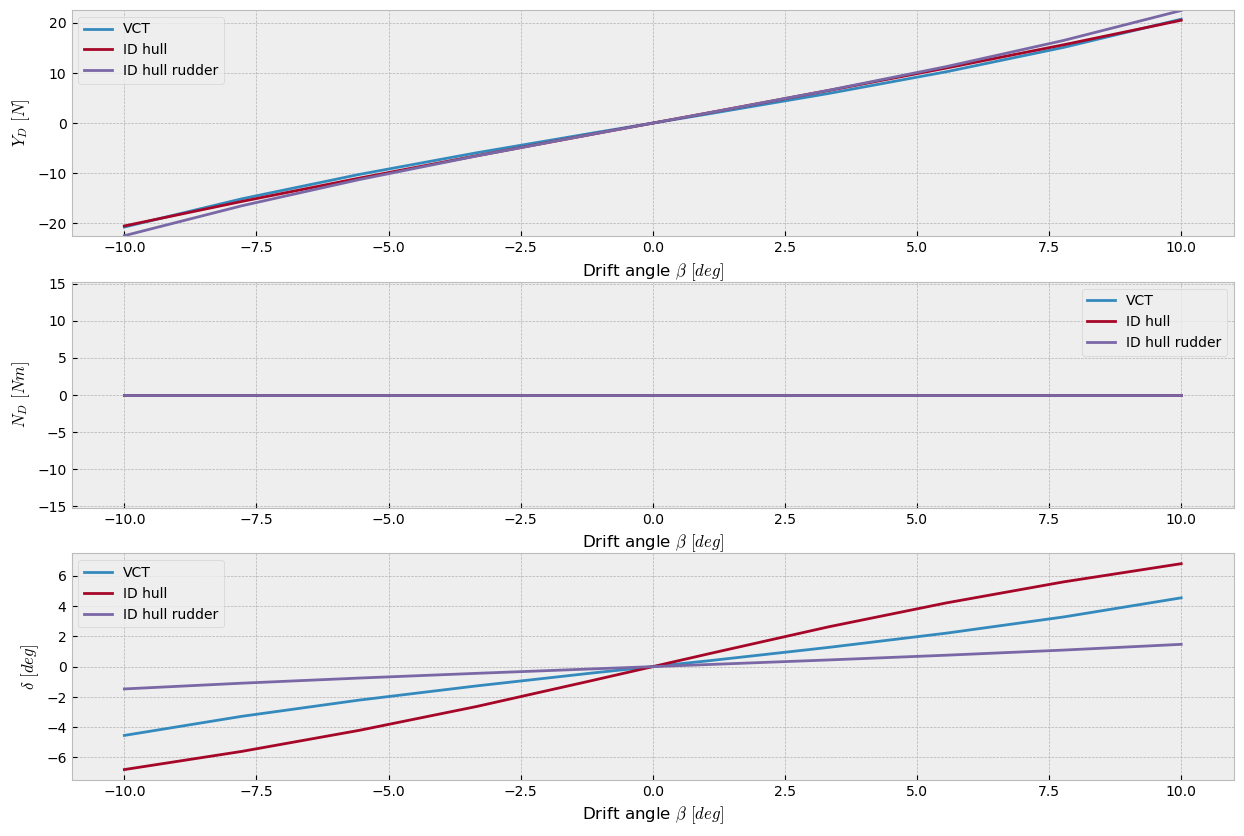

In [32]:
fig,axes=plt.subplots(nrows=3)

ylabels={
'delta_deg':r"$\delta$"
}

for ax,y,unit in zip(axes,['Y_D','N_D','delta_deg'],['N','Nm','deg']):

    for name,df in dataframes_optimized.items():
        df['beta_deg'] = np.rad2deg(df['beta'])
        df['delta_deg'] = np.rad2deg(df['delta'])
        
        df.plot(x='beta_deg', y=y, label=name, ax=ax)
    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
    ylabel= ylabels.get(y,fr'${y}$')
    ax.set_ylabel(fr'{ylabel} $[{unit}]$')
    if y in ylims:
        ax.set_ylim(ylims[y])